### Mapping NDVI utilising Sentinel-2 Cloud Optimsed GeoTIFFs

This was a small piece of work undertaken to get familiar with working with Cloud Optimised GeoTIFFs (COG) via Python. The objective was to map NDVI over time using Sentinel-2 imagery.
 
 

#### Cloud Optimsed GeoTIFFs
The Cloud Optimsed GeoTIFF (COG) format has seen a rapid adoption. This includes many providers of satellite imagery packaging their data in this format. One of advantages of the COG format is the ability to make range requests whereby just a subset of data within an image is requested.  

This concept is transformational when working with satellite imagery. Rather than downloading large images such as the Sentinel-2 100km X 100km granule at approximately 1GB, just the proportion of the image needed can be requested. This practice greatly reduces inefficiencies in data processing, data transfer and data management.  


#### NDVI 
The NDVI (Normalised Differenced Vegetation Index) is a common index in remote sensing for quantifying the abundance and health of vegetation.

Healthy vegetation absorbs the solar radiation that is required for photosynthesis while reflecting the solar radiation that is less useful and even harmful. This sees vegetation strongly absorb solar radiation in the visible part of the spectrum, while strongly reflecting near-infrared (NIR) radiation. By employing the NDVI calculation (as below) to ratio the absorption  and reflection of visible and NIR light, the presence and health of vegetation can be visually mapped. 

![NDVI calc](img/ndvi_1.png)
Above: The NDVI formula measures the difference between NIR (Near Infrared) and Red values to quantify vegetation.


![NDVI](img/ndvi_2.jpeg)
Above: Higher rates of NIR reflection and higher rates of visible light light absorption  indicate healthier vegetation via higher NDVI values.(Credit: NASA)"


The NDVI index values ranges from -1 to 1 with  higher values being considered healthier vegetation.

![plant state](img/plant_states.jpg)
Credit: eos.com


### Getting started
#### Key python libraries
This approach to mapping NDVI from COGs employs the following Python Libraries. 
* [rasterio](https://rasterio.readthedocs.io/en/latest/): for reading the COG images
* [satsearch](https://github.com/sat-utils/sat-search): for querying the image store metadata to filter images that meet; date, cloud and geospatial extent criteria 
* [matplotlib](https://matplotlib.org/): for displaying the imagery and analysis

#### Import Python libraries and set variables
* Import required python libraries 
* Use `%matplotlib inline` so the matplotlib graphs will be included in your notebook if using [Jupyter notebooks](https://jupyter.org/). 
* Set the variables including
  * `bbox`: The bounding box of the geospatial area of interest where NDVI is to be calculated
  * `date_range`: The date range of the Sentinel-2 images we are to request
  * `scene_cloud_tolerance`: The total cloud coverage tolerated in the entire Sentinel-2 scene. This is used by satsearch when querying metadata for suitable imagery
  * `subset_scene_cloud_tolerance`: How much cloud will be tolerated in the subset scene

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import rasterio
from rasterio.plot import show, reshape_as_image
from pyproj import Transformer
from satsearch import Search

%matplotlib inline

# sentinel-2 COG cloud store
url = "https://earth-search.aws.element84.com/v0/"

# cloud cover tolerances
scene_cloud_tolerance = 50 # (Variable) The % of cloud tolerated in the 100x100km Sentinel-2 scene
subset_scene_cloud_tolerance = 2 # (Variable) The % of cloud tolerated in the area of interest 

# Bounding Box delineating the spatial extent for NDVI mapping
bbox = [171.906166, -43.878840, 171.965904, -43.838489]

# The date range for mapping NDVI overtime
date_range = "2020-12-23/2021-12-23"

/usr/local/lib/python3.8/dist-packages/rasterio-1.1.8-py3.8-linux-x86_64.egg/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


To get and format the bounding box inputs I use QGIS and take the map canvas extents to use for the bounding box.
This can be done in the QGIS Python console as below once panning the map view to the area of interest.

```
extent = iface.mapCanvas().extent()
print([extent.xMinimum(), extent.yMinimum(), extent.xMaximum(), extent.yMaximum()])
```

#### Define functions
Define a few functions that will support requesting the required COG data. 



##### Range Requests
using the Rasterio `Window` method to request only the data within the bounding box. The affine transform is 
also returned as this allows for the transformation from the window's pixel coordinates to geospatial coordinates.   


In [2]:

transform_window = None
def range_request(image_url, bbox):
    """
    Request and read just the required pixels from the COG
    """
    
    with rasterio.open(image_url) as src:
        coord_transformer = Transformer.from_crs("epsg:4326", src.crs)
        # calculate pixels to be streamed from the COG
        coord_upper_left = coord_transformer.transform(bbox[3], bbox[0])
        coord_lower_right = coord_transformer.transform(bbox[1], bbox[2])
        pixel_upper_left = src.index(coord_upper_left[0], coord_upper_left[1])
        pixel_lower_right = src.index(coord_lower_right[0], coord_lower_right[1])
         
                
        # request only the bytes in the window
        window = rasterio.windows.Window.from_slices(
            (pixel_upper_left[0], pixel_lower_right[0]),
            (pixel_upper_left[1], pixel_lower_right[1]),
        )

        # The affine transform - This will allow us to 
        # translate pixels coordiantes back to geospatial coordiantes
        transform_window = rasterio.windows.transform(window,src.transform)
        
        bands = 1
        if "TCI" in image_url: # aka True Colour Image aka RGB
            bands = [1, 2, 3]

        subset = src.read(bands, window=window)
        return(subset, transform_window)

##### Querying the COG archive
Query the COG archive and return all items that meet the query criteria. 


In [3]:

def image_search(bbox, date_range, scene_cloud_tolerance):
    """
    Using SatSearch find all Sentinel-2 images
    that meet our criteria
    """
    
    search = Search(
        bbox=bbox,
        datetime=date_range,
        query={
            "eo:cloud_cover": {"lt": scene_cloud_tolerance}
        },  
        collections=["sentinel-s2-l2a-cogs"],
        url=url,
    )

    return search.items()

##### Filter for cloud in the subset scene
Filtering to only return scenes with a cloud coverage lower than a set threshold can be performed via satsearch. 
This however is based on the cloud cover metadata as calculated for the entire Sentinel-2 100x100km granule 
and while cloud may exist in most of a scene, the area of interest as represented by the bounding box may 
be cloud free and contain valuable data. 

Using the Sentinel-2 Scene Classification (SCL) band which indicates cloudy pixels, we can calculate the 
cloud cover for just the area of interest. This allows for a stratergy whereby entire scenes can be filtered 
on a higher cloud cover tolerance (e.g 50%) and then the proportion of the scene within the bounding box can 
be filtered on a lower tolerance (e.g 1%) maximising the total number of cloud free sub-scenes over the date range. 

This does create overhead and this step can be ignored by setting the `subset_scene_cloud_tolerance` to `None`

It should also be noted that the SCL data is not perfect and inaccuracies in the cloud bands can result in 
this method failing to filter all sub-scenes with cloud present. 



In [8]:
def is_cloudy(scl, tolerance):
    """
    Calculate the cloud cover in the subset-scene
    """
    
    image_size = scl.size
    unique, count = np.unique(scl, return_counts=True)
    counts = dict(zip(unique, count))

    # sum cloud types
    cloud_med_probability = counts.get(8, 0)
    cloud_high_probability = counts.get(9, 0)
    thin_cirrus = counts.get(10, 0)
    total_cloud_cover = cloud_med_probability + cloud_high_probability + thin_cirrus  
    
    # percent subscene cloud cover
    percent_cloud_cover = 100 * float(total_cloud_cover) / float(image_size)
    #print(f"\t cloud cover {percent_cloud_cover}%")
    if percent_cloud_cover > tolerance:
        return True
    return False

#### Calculate  NDVI

##### Get data within bounding box and calculate NDVI

* Iterate over the Sentinel-2 COG archive query results
* Assess the cloud coverage for the sub-scene within the bounding box
* If the cloud cover is below the cloud cover tolerance, request the subset data via the `range_request` method
* Calculate and store the NDVI data, RGB image and affine transform ready for time series visualisation. 

In [9]:
images= []

items = image_search(bbox, date_range, scene_cloud_tolerance)
for item in items:
    
    # Refs to images
    red = item.asset("red")["href"]
    nir = item.asset("nir")["href"]
    rgb = item.asset("visual")["href"]
    scl = item.asset("SCL")["href"]
    date = item.date.strftime("%d/%m/%Y")
    
    # if subset_scene_cloud_tolerance is set. check for 
    # clouds in sub-scene before continuing 
    if subset_scene_cloud_tolerance:
        #print(f"Assessing Cloud Cover: {date}")
        scl_subset, transform_window = range_request(scl, bbox)
        if is_cloudy(scl_subset, subset_scene_cloud_tolerance):
            #print(f"clouds in subset-scene: {date}")
            continue  

    # Streamed pixels within bbox
    red_subset, transform_window = range_request(red, bbox)
    nir_subset, transform_window = range_request(nir, bbox)
    rgb_subset, transform_window = range_request(rgb, bbox)

    # Calcualte NDVI
    ndvi_subset = (nir_subset.astype(float) - red_subset.astype(float)) / (
        nir_subset + red_subset
    )
    
    # Store the data for further processing
    images.append(
        {"date": date, "rgb": rgb_subset, "ndvi": ndvi_subset,'transform_window': transform_window}
    )

# reverse list as to be oldest to newest
images.reverse()

### Visualise the results
##### Visualise NDVI and RBG images side by side


##### Visualise all epochs as an animated time-series  
Using the  matplotlib animation library the above can be animated for visualisation. 

Here we also set the maximum and minimum (`vmin` and `vmax`) plot values to the full range of the possible
NDVI values to standardise the images for comparison and add a colour bar indicating the value of each 
pixel in the NDVI visualisation.  


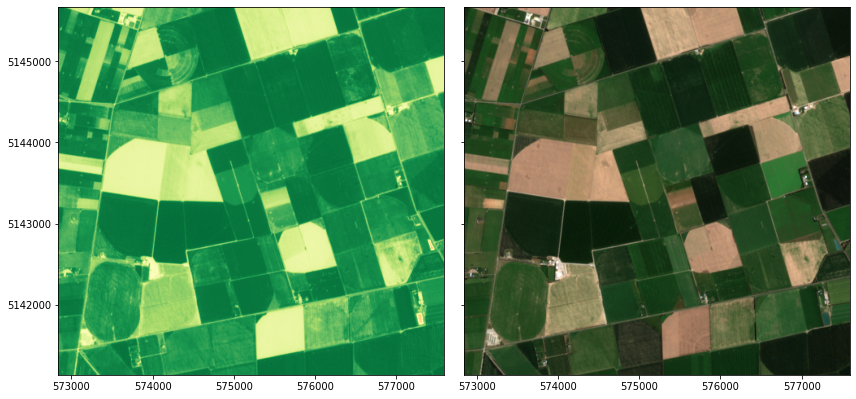

In [25]:
# ### Visualise NDVI and RBG images Side by Side
# num_images = len(images)
# width, height = 10, num_images * 4.5

# fig, subplots = plt.subplots(
#     len(images),
#     2,
#     sharex="col",
#     sharey="row",
#     figsize=(width, height),
#     constrained_layout=True,
# )

# for plot in zip(subplots, images):
#     ax = plot[0]
#     image = plot[1]
#     rgb_axes = show(image['ndvi'], 
#                     transform=image['transform_window'], 
#                     ax=ax[0], 
#                     alpha=.75,
#                     cmap="RdYlGn", 
#                     title=image["date"])
#     rgb_axes.ticklabel_format(style ='plain') # show full y-coords

#     show(image['rgb'], transform=image['transform_window'], ax=ax[1])

    
# Or just visualise the first one image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex="col", sharey="row")

ndvi_axes = show(images[-1]['ndvi'],
                  ax=ax1, 
                  transform=images[0]['transform_window'],
                  cmap="RdYlGn", 
                  vmin=-1, 
                  vmax=1, 
                 )
ndvi_axes.ticklabel_format(style ='plain') # use full y-coord text

rgb_axes = show(images[-1]['rgb'],ax=ax2, transform=images[0]['transform_window'])
plt.tight_layout()

In [26]:
# add title
title = ndvi_axes.text(
    0.5,
    1.100,
    "",
    bbox={"facecolor": "white", "alpha": 0.5, "pad": 5},
    transform=ax1.transAxes,
    ha="center",
    fontsize=18
)

#get the AxesImage
ndvi_axesimage = ndvi_axes.get_images()[0]
rgb_axesimage = rgb_axes.get_images()[0]

# colour bar
fig.colorbar(ndvi_axesimage, ax=ndvi_axes, shrink=0.72)
fig.colorbar(rgb_axesimage, ax=rgb_axes).remove()

def updatefig(i):
    """
    Animation function
    """

    ndvi_axesimage.set_array(images[i]["ndvi"])
    rgb_axesimage.set_array(reshape_as_image(images[i]["rgb"]))
    anim_title = title.set_text(images[i]["date"])
    return ndvi_axesimage, rgb_axesimage

ani = animation.FuncAnimation(
    fig, updatefig, frames=range(0, len(images)), interval=2000, blit=True
)


ani.save(
    filename="img/animation_sbs.gif",
    writer="imagemagick",
    fps=0.5,
    savefig_kwargs=dict(facecolor="#EAEAF2"),
)


![animation_sbs](img/animation_sbs.gif)
